In [7]:
import os
import time
import pandas as pd
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
train_df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_img_path = '../input/cassava-leaf-disease-classification/train_images/'
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [9]:
print('total number of train: {}'.format(len(train_df)))
print('class ratio:')
print(train_df['label'].value_counts()/len(train_df))

total number of train: 21397
class ratio:
3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64


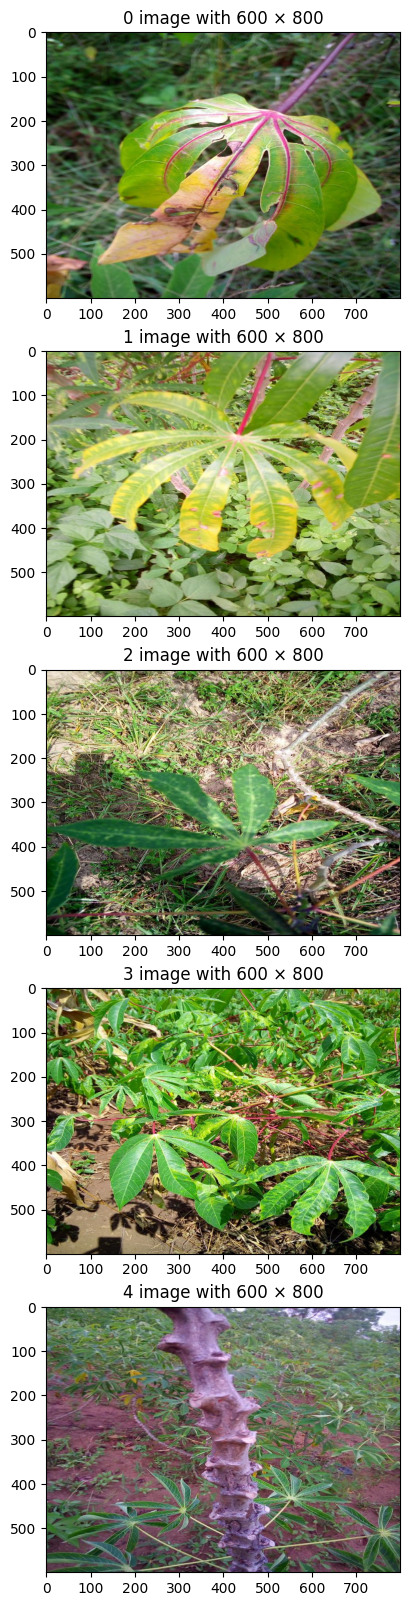

In [10]:
def plot_img_each_class(img_path:str, df:pd.DataFrame):
    fig = plt.figure(figsize=(50, 20))
    len_classes = len(df['label'].unique())
    
    for i in range(len_classes):
        ax = fig.add_subplot(len_classes, 1, i+1)
        sample = df[df['label'] == i]['image_id'].sample().reset_index(drop=True)
        img = cv2.imread(img_path + sample.iloc[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title('{} image with {} × {}'.format(i, img.shape[0], img.shape[1]))
        
    plt.show()

plot_img_each_class(train_img_path, train_df)

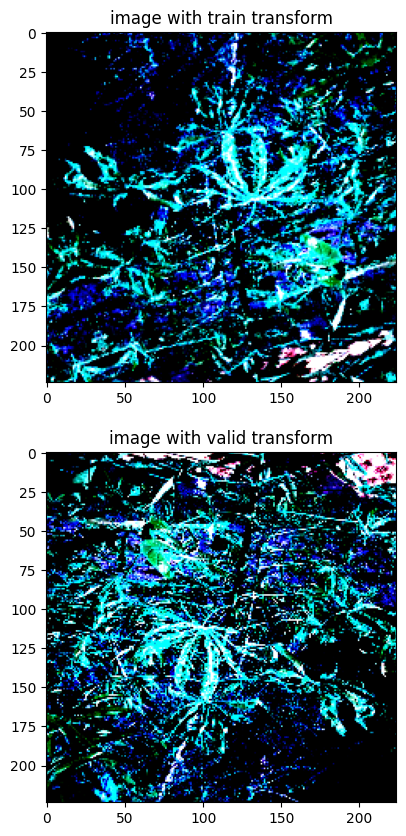

Train data's shape: torch.Size([3, 224, 224])
Train data's label: 0


In [11]:
# create Dataset
class CassavaDataset(Dataset):
    def __init__(self, df:pd.DataFrame, img_path:str, mode:str='train', transform:object=None):
        self.df = df
        self.img_path = img_path
        self.mode = mode
        self.transform = transform
    
    def __getitem__(self, idx):
        data_path = os.path.join(self.img_path, self.df['image_id'].iloc[idx])
        x = cv2.imread(data_path)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            x = transform(x, self.mode)
        
        if self.mode == 'test':
            return x
            
        label = self.df['label'].iloc[idx]
        
        return x, label
    
    def __len__(self):
        return len(self.df)

# create transform
class Transform(object):
    def __init__(self, resize, mean, std):
        self.transform = {
            'train': A.Compose([
                A.Resize(resize, resize),
                A.HorizontalFlip(0.5),
                A.VerticalFlip(0.5),
                A.ShiftScaleRotate(scale_limit=0, p=0.5),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()]),
            'val':A.Compose([
                A.Resize(resize, resize),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ]),
            'test':A.Compose([
                A.Resize(resize, resize),
                A.Normalize(mean=mean, std=std),
                ToTensorV2()
            ]),
        }
        
    def __call__(self, x, mode):
        return self.transform[mode](image=x)['image']
    
# check moving of transform
fig = plt.figure(figsize=(20,10))

# set parameters for VGG
resize = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = Transform(resize, mean, std)
img_for_check = cv2.imread(train_img_path + train_df['image_id'].sample().reset_index(drop=True).iloc[0])
img_train_transform = transform(img_for_check, 'train')
img_valid_transform = transform(img_for_check, 'val')
ax = fig.add_subplot(2,1,1)
plt.imshow(img_train_transform.numpy().transpose(1,2,0))
plt.title('image with train transform')

ax = fig.add_subplot(2,1,2)
plt.imshow(img_valid_transform.numpy().transpose(1,2,0))
plt.title('image with valid transform')

plt.show()

# check moving of dataset
idx = 0
dataset = CassavaDataset(train_df, train_img_path, 'train', transform)
print("Train data's shape: {}".format(dataset.__getitem__(idx)[0].size()))
print("Train data's label: {}".format(dataset.__getitem__(idx)[1]))

In [12]:
# create DataLoader
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'].values)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

transform = Transform(resize, mean, std)

train_dataset = CassavaDataset(train, train_img_path, 'train', transform)
val_dataset = CassavaDataset(val, train_img_path, 'val', transform)

batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# create VGG model
import torch.nn as nn
import torch.nn.functional as F

class VGG(nn.Module):
    def __init__(self, num_classes:int=5, num_layer:str='16'):
        super(VGG, self).__init__()
        self.num_layer = num_layer
        
        self.conv01 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv02 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.pool01 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv03 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv04 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.pool02 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv05 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv06 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        self.conv07 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        self.pool03 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        if num_layer == '19':
            self.conv_extralayer_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
            
        self.conv08 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv09 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.pool04 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        if num_layer == '19':
            self.conv_extralayer_2 = nn.Conv2d(in_channels=512, out_channels=512, stride=2)
            
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        self.pool05 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        if num_layer == '19':
            self.conv_extralayer_3 = self.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
            
        self.avepool1 = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.fc1 = nn.Linear(512*7*7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv01(x))
        x = F.relu(self.conv02(x))
        x = self.pool01(x)
        
        x = F.relu(self.conv03(x))
        x = F.relu(self.conv04(x))
        x = self.pool02(x)
        
        x = F.relu(self.conv05(x))
        x = F.relu(self.conv06(x))
        x = F.relu(self.conv07(x))
        if self.num_layer == '19':
            x = F.relu(self.conv_extralayer_1(x))
        x = self.pool03(x)
        
        x = F.relu(self.conv08(x))
        x = F.relu(self.conv09(x))
        x = F.relu(self.conv10(x))
        if self.num_layer == '19':
            x = F.relu(self.conv_extralayer_2(x))
        x = self.pool04(x)
        
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        if self.num_layer == '19':
            x = F.relu(self.conv_extralayer_3(x))
        x = self.pool05(x)
        x = self.avepool1(x)
        x = x.view(-1, 512*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

In [14]:
# training
import torch
import torch.optim as optim 
from tqdm import tqdm

def train_model(model, dataloader_dict, optimizer, criterion, device, epochs=5, scheduler=None):
    since = time.time()
    best_acc = 0.0
    
    if device == 'cuda':
        model = nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True
    
    for epoch in range(epochs):
        print('Epoch : {}/{}'.format(epoch+1, epochs+1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / (len(dataloader_dict[phase]) * batch_size)
            epoch_acc = running_corrects.double() / (len(dataloader_dict[phase]) * batch_size)
            
            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'Best_VGG.pth')
                
        print()
        
    time_elapced = time.time() - since
    print('Training complete: {}m {}s'.format(time_elapced//60, time_elapced%60))
    print('Best val Acc: {}'.format(best_acc))
    

epochs = 5
model = VGG()
dataloader_dict = {'train':train_dl, 'val':val_dl}
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_model(model, dataloader_dict, optimizer, criterion, device, epochs, scheduler)

In [15]:
# load best weight
model.load_state_dict(torch.load('../input/baseline-vgg16/Best_VGG.pth'))
model = model.to(device)

In [17]:
# test submission
test_df = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
test_img_path = '../input/cassava-leaf-disease-classification/test_images'

test_dataset = CassavaDataset(test_df, test_img_path, 'test', transform)
test_dl = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

predictions = []

for inputs in tqdm(test_dl):
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.to('cpu')
    predictions.append(preds)
    
test_df['label'] = np.concatenate(predictions)
test_df.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1/1 [00:05<00:00,  5.00s/it]
